# Wildfire Analysis for Lubbock,Texas

This notebook contains the code for estimating impact of smoke caused by wildfires on the city of Lubbock, Texas. Parts of the code used for processing the JSON file contianing geographic information were adapted from [example code](https://drive.google.com/file/d/1B7AGlaW7d-27bHKLVXGBwLt8T-Elx-HB/view?usp=drive_link) provided by Dr.David McDonald. 
Further the regular expression code to process start and end dates for fires was shared by [Himanshu J. Naidu](https://github.com/himanshunaidu/data512_project/blob/master/wildfire_data_acquisition.ipynb). 

## Loading the dependencies

We first start off by loading our dependencies for our analysis. 
If you find that any of these dependencies are missing, run ```pip install <package-name>```

In [13]:
import numpy as np
import pandas as pd
import geojson
import time
import json
from pyproj import Transformer, Geod
import regex as re
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy import stats

# Data

The data used for this analysis was the [ USGS data for Combined wildland fire datasets for the United States and certain territories, 1800s-Present (combined wildland fire polygons) ](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81), specifically the [GeoJSON_Files.zip file](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81) The data was collected and compiled by the US Geological Survey. The data includes geographic information for wildfires in the USA ranging from 1800 to 2021.
The geometry in the data are polygons that are expressed in a coordinate system with the well-known ID (WKID) 102008,which also known as [ESRI:102008](https://epsg.io/102008).

The GeoJSON has the following higher level keys:
- 'displayFieldName'
- 'fieldAliases'
- 'geometryType'
- 'spatialReference'
- 'fields'
- 'features'
where 'features' represents one wildfire in the data set and includes (but not limited to) the following information:
- Fire type ranging from Wildfire,Likely Wildfire, Unknown-Likely Wildfire, Unknown- Likely Prescribed Fire, Prescibed Fire
- Fire year
- Assigned Fire Names (if any)
- GIS Acres and Hectares burned
- rings: A list of polygon rings defining the overall fire polygon, with the first one denoting the fire perimeter.
- curveRings: A list of polygon curveRings defining the overall shape, with the first one denoting the fire perimeter



In [ ]:
geojson_file = open("/kaggle/input/usgs-wildland-fire-combined-dataset/USGS_Wildland_Fire_Combined_Dataset.json","r")
#geojson_file = open("/kaggle/input/wildfire-short-sample/Wildfire_short_sample_2024.json","r") #Subset of the data that could be used for testing
gj_data = geojson.load(geojson_file)

In [ ]:
print(f"There are {len(gj_data['fields'])} fields (# of attributes per observation).")
print(f"There are {len(gj_data['features'])} features (# of observations).")
print(f"The header has the following keys:\n{list(gj_data.keys())}")

In [2]:
# Defining the constants to be used in our code here

LUBBOCK_LAT_LON = [34.12, -117.39] # latitude and longitude of Lubbock, Texas
#ENCINITAS_LAT_LON = [33.0370, -117.2920]
ALPHA = 0.5 # Weightage coefficient for distance of wildfire from the city
BETA = 1-ALPHA # Weightage coefficient for the size of the wildfire - measured in the acres burnt
GAMMA_MAP = { 
    'Wildfire': 4,
    'Likely Wildfire': 3,
    'Unknown - Likely Wildfire': 2,
    'Unknown - Likely Prescribed Fire': 1,
    'Prescribed Fire': 0
    } # Weightage to be added to the smoke estimate based on the scale/type of the fire

# Constants defined to filter based on fire season viz May 1st to Oct 31st of any year
START_YEAR = 1961
FIRE_FIRST_DATE_COL = 'Fire_First_Date'
FIRE_LAST_DATE_COL = 'Fire_Last_Date'

DEFAULT_FIRST_DD_MM = '05-01'
DEFAULT_LAST_DD_MM = '10-31'
FIRST_DATE_POSSIBLE_KEYS = [
    'Listed Ignition Date(s)',
    'Listed Wildfire Discovery Date(s)',
    'Listed Prescribed Fire Start Date(s)',
    'Prescribed Fire Start Date'
    'Listed Other Fire Date(s)'
]
LAST_DATE_POSSIBLE_KEYS = [
    'Listed Wildfire Controlled Date(s)',
    'Listed Wildfire Containment Date(s)'
    'Listed Wildfire Out Date(s)',
    'Prescribed Fire End Date',
]# Fields which could potentially give us information about the exact date of the wildfire occurance

## Filtering the data

We filter the data based on the following critieria
1. Year range between 1961 and 2021.
2. Distance for the city is at most 1800 miles. Note that in the smoke estimate, we only consider fires that are 650 miles away from the city but for visualization purposes, we include a broader radius of 1800 miles
3. Fires occuring during fire season of a given year i.e between May and Oct. If we are unable to parse a date including month for a given fire, we assume that it was in the fire season and proceed.

In [ ]:
# Code snippet credited to Himanshu J. Naidu

first_date_keys_pattern = '|'.join(re.escape(key) for key in FIRST_DATE_POSSIBLE_KEYS)
first_date_pattern = rf"({first_date_keys_pattern}):\s*(\d{{4}}-\d{{2}}-\d{{2}})\b"

def get_first_dates(fire_feature_row, default_start_dd_mm=DEFAULT_FIRST_DD_MM, default_year=START_YEAR):
    """
    Get the start date of the fire from Listed_Fire_Dates.
    Currently, checks if any one of the date keys is in the list of FIRST_DATE_POSSIBLE_KEYS (in order).

    Parameters:
    ----------
    fire_feature_row (pd.Series): A row from the fire feature GeoDataFrame.

    default_start_dd_mm (str): The default start date (MM-DD) to use if no valid date is found.

    default_year (int): The default year to use if no valid date is found.
    
    Returns:
    ----------
    str: The first date of the fire feature.
    """
    # Check if the fire feature row has a valid date
    match = re.search(first_date_pattern, fire_feature_row['Listed_Fire_Dates'])

    date = None
    # If a match is found, return the date string
    if match:
        date = match.group(2)  # Group 2 captures the date
    else:
        date = f"{fire_feature_row['Fire_Year'] or default_year}-{default_start_dd_mm}"
    return date

last_date_keys_pattern = '|'.join(re.escape(key) for key in LAST_DATE_POSSIBLE_KEYS)
last_date_pattern = rf"({last_date_keys_pattern}):\s*(\d{{4}}-\d{{2}}-\d{{2}})\b"

def get_last_dates(fire_feature_row, default_end_dd_mm=DEFAULT_LAST_DD_MM, default_year=START_YEAR):
    # Check if the fire feature row has a valid date
    match = re.search(last_date_pattern, fire_feature_row["Listed_Fire_Dates"])

    date = None
    # If a match is found, return the date string
    if match:
        date = match.group(2)  # Group 2 captures the date
    else:
        date = f"{fire_feature_row['Fire_Year'] or default_year}-{default_end_dd_mm}"
    return date

The following code snippets to: <br>
a) convert ring data into distance in miles and b) to find distance of a fire from the assigned city was provided by Dr.David McDonald.
Every feature has a 'geometry' which specifies geo coordinates that represent a geographic object ans in this case the wildfires are bounded shapes, circles, squares and so on represented by the 'rings' field in GeoJSON. The largest shape (ring) is supposed to be item zero in the list of 'rings'.
One caveat of performing calcualtions on the geo coordinates directly is that since they represent points on the earth and the earth is not flat,the computation of distance between two points is more of an arc as opposed to a straight line and varies depending on the position of the two points. To mitigate this issue, we use the PyProj module to accurately calculate the straight line distance between our geographic coordinates.

In [ ]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        try:
            lat,lon = to_epsg4326.transform(coord[0],coord[1])
            new_coord = lat,lon
            converted_ring.append(new_coord)
        except:
            print("Failed to convert to espg4326")
    return converted_ring

To calculate the distance of a fire from a given city we have two options:
1) To calculate distance based on the perimeter of the fire, using the point on the fire perimeter closest to the city as the starting point
2) To calculate the average distance of all points on the fire perimeter to the given city - this is roughly the same as calculating the distance from the centeroid.

Since the fires could have irreguarly shaped boundaries, we choose to go with the second apporach of measuring distance from roughly the center of the fire to the city. 

In [ ]:
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point


#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

In [ ]:
def filter_closest_wildfires(wf_feature):
    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        raise Exception("No compatible geometry in this fire data")

    distance = average_distance_from_place_to_fire_perimeter(LUBBOCK_LAT_LON,ring_data)
    wf_year = wf_feature['attributes']['Fire_Year']
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    return distance <= 1800 and wf_year >= 1961

To calculate the smoke estimate, we consider the following fields: GIS acres burned (Wildfire size), distance from the Wildfire to Lubbock (calculated as described above) and the type of wildfire.
The impact of a wildfire is most likely influenced directly by how big the wildfire was - the GIS acres burned and the type of wildfire capture this. The impact of wildfire is also likely to be less severe if it occurs at a greater distance from Lubbock and vice-versa. So we consider the smoke estimate to be directly proportional to wildfire size and inversely proportional to distance from city and also influenced to varying degrees based on wildfire type. To capture this, we come up with the following relationship between smoke estimate and the fields considered: $$Smoke\_estimate = \alpha * (\frac{1}{distance}) * \beta * size + \gamma $$ where $\alpha$ and $\beta$ are tunable weightage given to distance of wildfire from city and size of wildfire respectively. These account for the proportinality constant as well. $\gamma$ is an additonal weight added upon based on the ordinal mapping between the type of wildfire and the proabable severity. The ordinal mapping is as follows:
```
 { 
    'Wildfire': 4,
    'Likely Wildfire': 3,
    'Unknown - Likely Wildfire': 2,
    'Unknown - Likely Prescribed Fire': 1,
    'Prescribed Fire': 0
    }
 ```
 The value of $\alpha$ and $\beta$ are set to 0.5 so as to give distance and wildfire size equal weightage while computing smoke estimate.

In [ ]:
def calculate_smoke_estimate(wf_feature):
    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        raise Exception("No compatible geometry in this fire data")
    distance = average_distance_from_place_to_fire_perimeter(LUBBOCK_LAT_LON,ring_data)
    if distance <=650:
        wf_size = wf_feature['attributes']['GIS_Acres']
        wf_type = wf_feature['attributes']['Assigned_Fire_Type']
        gamma_value = GAMMA_MAP[wf_type]
        smoke_estimate_weighted = ALPHA * (1/distance * BETA) * wf_size + gamma_value
        return (smoke_estimate_weighted,distance)
    else:
        return 0,distance

In [ ]:
# Iterating through the json file and filtering out the fires that meet our conditions
# We then find smoke estimate/ impact of each fire on Lubbock
df_estimates = pd.DataFrame(columns=["name", "year", "start date", "end date", "type", "distance", "size", "smoke estimate"])
for wf_feature in gj_data['features']:
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_year = wf_feature['attributes']['Fire_Year']
    wf_size = wf_feature['attributes']['GIS_Acres']
    print(wf_name, wf_year)
    try:
        if filter_closest_wildfires(wf_feature):
            smoke_est_weighted,distance = calculate_smoke_estimate(wf_feature)
            wf_type = wf_feature['attributes']['Assigned_Fire_Type']
            wf_start_date = get_first_dates(wf_feature['attributes'])
            wf_end_date = get_last_dates(wf_feature['attributes'])
            # Add a new row without checking for duplicates
            new_row = pd.DataFrame({
                "name": [wf_name],
                "year": [wf_year],
                "start date": [wf_start_date],
                "end date": [wf_end_date],
                "type": [wf_type],
                "distance":[distance],
                "size":[wf_size],
                "smoke estimate": [smoke_est_weighted]
            })
            df_estimates = pd.concat([df_estimates, new_row], ignore_index=True)
    except Exception as e:
        print("Parsing failed for Fire:", wf_name, wf_year)
        print(e)
        continue
        
df_estimates.head(25)

In [ ]:
# if there are null values due to parsing issues, fill it with 0
df_estimates_yearly = df_estimates.fillna(0)

In [ ]:
df_estimates.to_csv("wildfire_smoke_estimate.csv")

## Visualzing trends in smoke estimates

Seems like our smoke estimates are tending downwards which indicates lesser number of high impact wildfires within 650 miles of Lubbock,Texas over the years.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


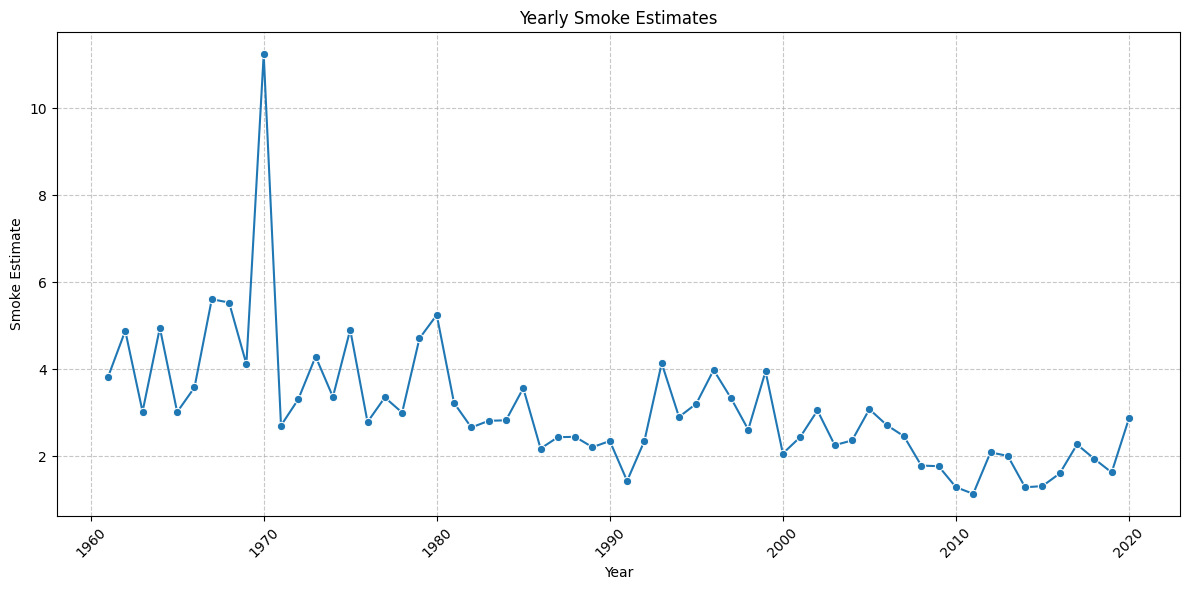

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_estimates_yearly, x="year", y='smoke estimate', 
             marker='o')
plt.title('Yearly Smoke Estimates')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comparision with AQI

We use the Air Quality index as a metric to compare and sanity test our smoke estimate. We get the AQI data from  US EPA Air Quality System (AQS) API. We calcualte yearly smoke estimates and yearly AQI for Lubbock and check for correlation between the two.

In [3]:
df_estimates = pd.read_csv("/kaggle/input/wildfire-smoke-and-aqi-data/wildfire_smoke_estimate.csv")
aqi_data = pd.read_csv("/kaggle/input/wildfire-smoke-and-aqi-data/yearly_AQI_1961-2021.csv")

In [4]:
df_estimates.head()

,Unnamed: 0,name,year,start date,end date,type,distance,size,smoke estimate
0,0,BIG ANTELOPE (5),1961,1961-09-08,1961-10-31,Wildfire,496.813337,55249.740141,31.802062
1,1,HARLOW (5),1961,1961-07-10,1961-10-31,Wildfire,252.905017,43920.841077,47.416340
2,2,RANCHERIA (5),1961,1961-09-02,1961-10-31,Wildfire,352.823877,34233.698603,28.256932
3,3,BOLLINGER RIDGE (5),1961,1961-07-12,1961-10-31,Wildfire,313.182832,32866.053451,30.235517
4,4,Ditch Creek (3),1961,1961-09-01,1961-10-31,Wildfire,754.511077,27269.045936,0.000000


In [5]:
df_estimates['start date'] = pd.to_datetime(df_estimates['start date'])
df_estimates['end date'] = pd.to_datetime(df_estimates['end date'])

# Define May 1st and October 31st for the filter
may_1 = pd.to_datetime(f"{df_estimates['year'].iloc[0]}-05-01")
oct_31 = pd.to_datetime(f"{df_estimates['year'].iloc[0]}-10-31")

# Filter the DataFrame
filtered_df = df_estimates[(df_estimates['start date'] >= may_1) & (df_estimates['end date'] <= oct_31)]

# Display the filtered DataFrame
print(filtered_df)

       Unnamed: 0                          name  year start date   end date  \
0               0              BIG ANTELOPE (5)  1961 1961-09-08 1961-10-31   
1               1                    HARLOW (5)  1961 1961-07-10 1961-10-31   
2               2                 RANCHERIA (5)  1961 1961-09-02 1961-10-31   
3               3           BOLLINGER RIDGE (5)  1961 1961-07-12 1961-10-31   
4               4               Ditch Creek (3)  1961 1961-09-01 1961-10-31   
...           ...                           ...   ...        ...        ...   
89029       89029            Conde Creek #3 (1)  1961 1961-05-01 1961-10-31   
89030       89030                   No Data (1)  1961 1961-05-01 1961-10-31   
89031       89031     Section Line Gap #204 (1)  1961 1961-05-01 1961-10-31   
89032       89032  Trigger Finger TS Sec. 7 (1)  1961 1961-05-01 1961-10-31   
89033       89033       Sourgrass-f.s. Road (1)  1961 1961-05-01 1961-10-31   

                  type    distance          size  s

In [6]:
def most_frequent(series):
    return series.mode().iloc[0] if not series.mode().empty else None

In [7]:
df_estimates['start date'] = pd.to_datetime(df_estimates['start date'])
df_estimates['end date'] = pd.to_datetime(df_estimates['end date'])

# Defining the month-day range for filtering (May 1 to October 31)
start_month_day = (5, 1)
end_month_day = (10, 31)

# Filter for start and end dates within the May 1 to October 31 range
filtered_df = df_estimates[
    ((df_estimates['start date'].dt.month > start_month_day[0]) | 
     ((df_estimates['start date'].dt.month == start_month_day[0]) & (df_estimates['start date'].dt.day >= start_month_day[1]))) &
    ((df_estimates['end date'].dt.month < end_month_day[0]) | 
     ((df_estimates['end date'].dt.month == end_month_day[0]) & (df_estimates['end date'].dt.day <= end_month_day[1])))
]

# Aggregate by year, summing only 'smoke estimate' while keeping other columns with the first occurrence/most frequent occurance
df_estimates_yearly = filtered_df.groupby("year").agg({
    'smoke estimate': 'mean',
    'name': most_frequent,
    'type': most_frequent,
    'distance': 'first',
    'start date': 'first',
    'end date': 'first'
}).reset_index()

# Display the result
print(df_estimates_yearly)



    year  smoke estimate                       name             type  \
0   1961        3.821763  No Fire Name Provided (2)         Wildfire   
1   1962        4.889831  No Fire Name Provided (2)         Wildfire   
2   1963        3.030857  No Fire Name Provided (2)         Wildfire   
3   1964        4.957009  No Fire Name Provided (2)         Wildfire   
4   1965        3.022106                No Data (1)         Wildfire   
5   1966        3.586299  No Fire Name Provided (2)         Wildfire   
6   1967        5.614818  No Fire Name Provided (2)         Wildfire   
7   1968        5.538423  No Fire Name Provided (4)         Wildfire   
8   1969        4.122835           Not Assigned (2)         Wildfire   
9   1970       11.244242  No Fire Name Provided (2)         Wildfire   
10  1971        2.711365  No Fire Name Provided (2)         Wildfire   
11  1972        3.316320  No Fire Name Provided (2)         Wildfire   
12  1973        4.297308  No Fire Name Provided (2)         Wild

In [8]:
aqi_data.head()

,Unnamed: 0,year,aqi
0,0,1969,12.000000
1,1,1970,10.000000
2,2,1971,5.500000
3,3,1972,6.629630
4,4,1973,22.384615


In [9]:
# Assuming aqi_data is your initial data
full_years = pd.DataFrame({'year': range(1961, 2022)})

# Merge with the original data to fill in missing years
df_aqi_full = pd.merge(full_years, aqi_data, on='year', how='left')

df_aqi_full['aqi'] = df_aqi_full['aqi'].fillna(0)
df_aqi_full = df_aqi_full.loc[:, ~df_aqi_full.columns.str.contains('^Unnamed')]

# Display the result
print(df_aqi_full)


    year        aqi
0   1961   0.000000
1   1962   0.000000
2   1963   0.000000
3   1964   0.000000
4   1965   0.000000
..   ...        ...
56  2017   0.000000
57  2018  34.485981
58  2019  38.820359
59  2020  35.859551
60  2021  38.871508

[61 rows x 2 columns]


In [10]:
df_aqi_smoke = pd.merge(df_estimates_yearly,df_aqi_full, on='year', how='left')

In [11]:
print(df_aqi_smoke)

    year  smoke estimate                       name             type  \
0   1961        3.821763  No Fire Name Provided (2)         Wildfire   
1   1962        4.889831  No Fire Name Provided (2)         Wildfire   
2   1963        3.030857  No Fire Name Provided (2)         Wildfire   
3   1964        4.957009  No Fire Name Provided (2)         Wildfire   
4   1965        3.022106                No Data (1)         Wildfire   
5   1966        3.586299  No Fire Name Provided (2)         Wildfire   
6   1967        5.614818  No Fire Name Provided (2)         Wildfire   
7   1968        5.538423  No Fire Name Provided (4)         Wildfire   
8   1969        4.122835           Not Assigned (2)         Wildfire   
9   1970       11.244242  No Fire Name Provided (2)         Wildfire   
10  1971        2.711365  No Fire Name Provided (2)         Wildfire   
11  1972        3.316320  No Fire Name Provided (2)         Wildfire   
12  1973        4.297308  No Fire Name Provided (2)         Wild

We calculated Pearson correlation coefficient between yearly smoke estimates and AQI and we find a weak neagtive correlation. The Pearson correlation coefficient makes a number of assumptions about the underlying distribution such as normality assumptions. Our data doesn't meet these assumptions so we cannot rely on the Pearson coefficient. To check for non-linear realtionships,we check Spearman and Kendall coefficients which also only indicate weak correlation. Spearman and Kendall correlation coefficients are non-parametric in nature and do not rely on assumptions about the underlying data distribution.

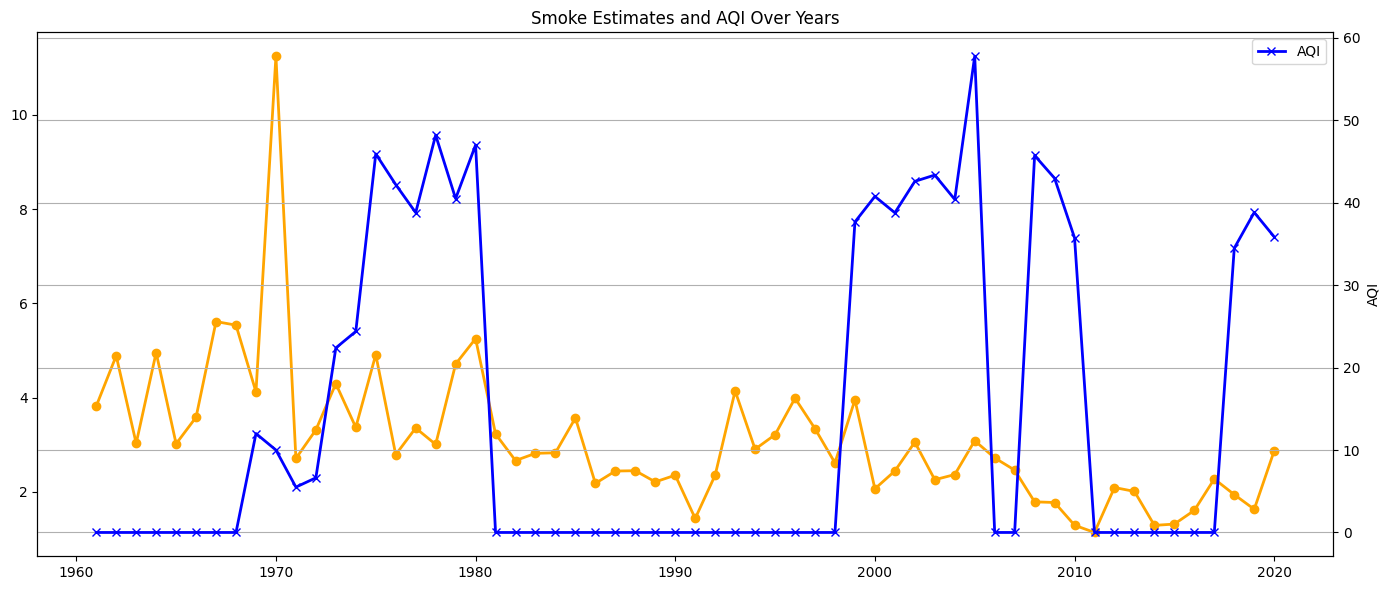

In [14]:
plt.figure(figsize=(14, 6))

# Create a plot for smoke estimates
plt.plot(df_aqi_smoke['year'], df_aqi_smoke['smoke estimate'], color='orange', marker='o', label='Smoke Estimate', linewidth=2)

# Create a secondary y-axis for AQI
ax2 = plt.gca().twinx()  # Create a twin Axes sharing the x-axis
ax2.plot(df_aqi_smoke['year'], df_aqi_smoke['aqi'], color='blue', marker='x', label='AQI', linewidth=2)

# Title and labels
plt.title('Smoke Estimates and AQI Over Years')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate (in 1000s)')
ax2.set_ylabel('AQI')  # Set the label for the secondary y-axis
plt.xticks(rotation=45)
plt.grid()

# Add legends for both axes
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.show()

Looking at the trends of AQI and smoke estimate they don't seem to have a clear relation either. Note that the flat 0s on the AQI plot are points in time for which there is no AQI data available. 

In [15]:
# Calculate different types of correlations
pearson_corr = df_aqi_smoke['smoke estimate'].corr(df_aqi_smoke['aqi'], method='pearson')
spearman_corr = df_aqi_smoke['smoke estimate'].corr(df_aqi_smoke['aqi'], method='spearman')
kendall_corr = df_aqi_smoke['smoke estimate'].corr(df_aqi_smoke['aqi'], method='kendall')

# Print the correlation results
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")
print(f"Kendall Correlation: {kendall_corr}")


Pearson Correlation: -0.010494941020912517
Spearman Correlation: 0.05846784222938628
Kendall Correlation: 0.047845767357425836


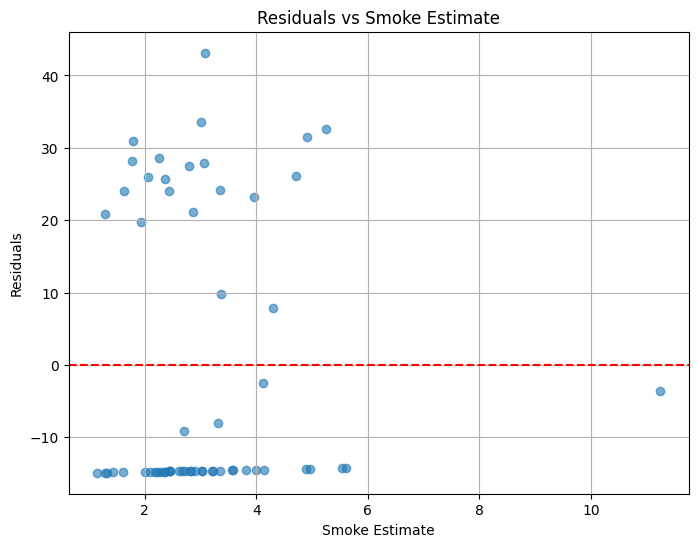

In [16]:

import statsmodels.api as sm

# Fit a linear regression model
X = sm.add_constant(df_aqi_smoke['smoke estimate'])  # Add a constant for the intercept
model = sm.OLS(df_aqi_smoke['aqi'], X).fit()

# Calculate residuals
residuals = model.resid

# Plot residuals to check for homoscedasticity
plt.figure(figsize=(8, 6))
plt.scatter(df_aqi_smoke['smoke estimate'], residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Smoke Estimate')
plt.xlabel('Smoke Estimate')
plt.ylabel('Residuals')
plt.grid()
plt.show()


The residuals plot can also be used to check if smoke estimate and AQI are linearly related. From the plot above we can conclude that they are not linearly related since we observe several distinctive patterns. The residuals demonstrate significant clustering, particularly around smoke estimates between 2-6, with many points concentrated in a horizontal band around -15 residuals. There's also a notable variation in the spread of residuals across different smoke estimate values, creating what appears to be a fan or wedge shape pattern, especially prominent at lower smoke estimates. The residuals show a wide vertical spread ranging from approximately -15 to 45, and they don't exhibit the random scatter around the zero line (marked by the red dashed line) that would be expected in a linear relationship. This heteroscedasticity, or uneven spread of residuals, combined with the systematic patterns in the plot, strongly suggests that a linear model is not appropriate for this data, and the relationship between these variables would be better captured using a non-linear modeling approach.

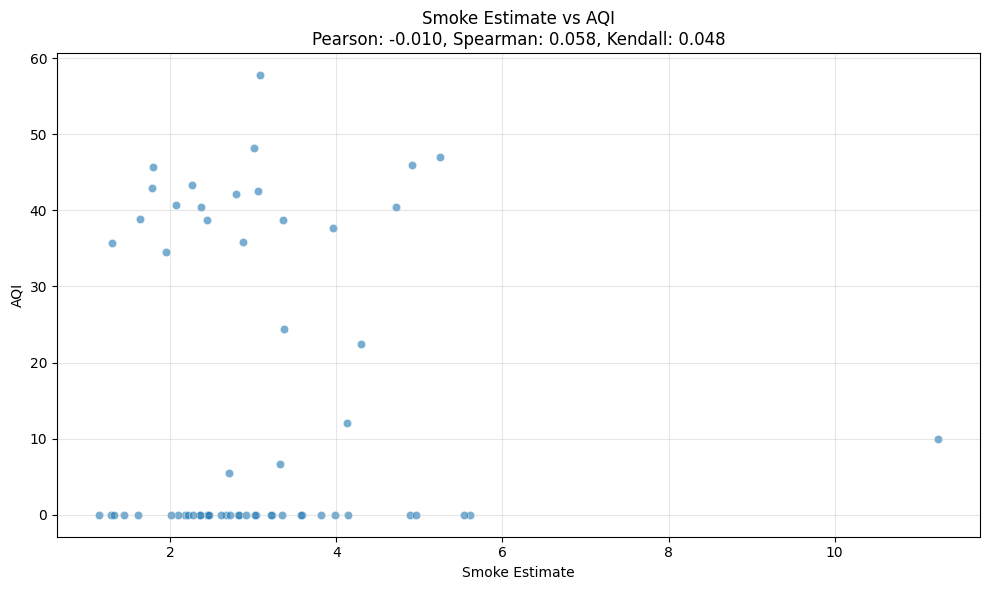

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(10, 6))

# Create scatter plot
sns.scatterplot(data=df_aqi_smoke, x='smoke estimate', y='aqi', alpha=0.6)

# Customize the plot
plt.title('Smoke Estimate vs AQI\n' + 
         f'Pearson: {pearson_corr:.3f}, ' +
         f'Spearman: {spearman_corr:.3f}, ' +
         f'Kendall: {kendall_corr:.3f}')
plt.xlabel('Smoke Estimate')
plt.ylabel('AQI')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Observing the scatterplot, we don't see any noticeable non-linear patterns either so we can assume that the current smoke estimate and AQI values are not really related to each other.

## Forecasting smoke estimates for next 25 years

We use timeseries models namely the exponential smooting model and ARIMA to forecast the some estimate for the next 25 years. These models are best suited for yearly data without any seasonality in them. Since our smoke estimates are yearly data, we employ these models for forecasting. Based on the MSE, MAE and MAPE accuracy metrics, we see that exponential smoothing performs slightly better than ARIMA


Model Performance Metrics:

Exponential Smoothing:
RMSE: 1.21
MAE: 0.78
MAPE: 25.73

ARIMA:
RMSE: 1.37
MAE: 0.90
MAPE: 28.64


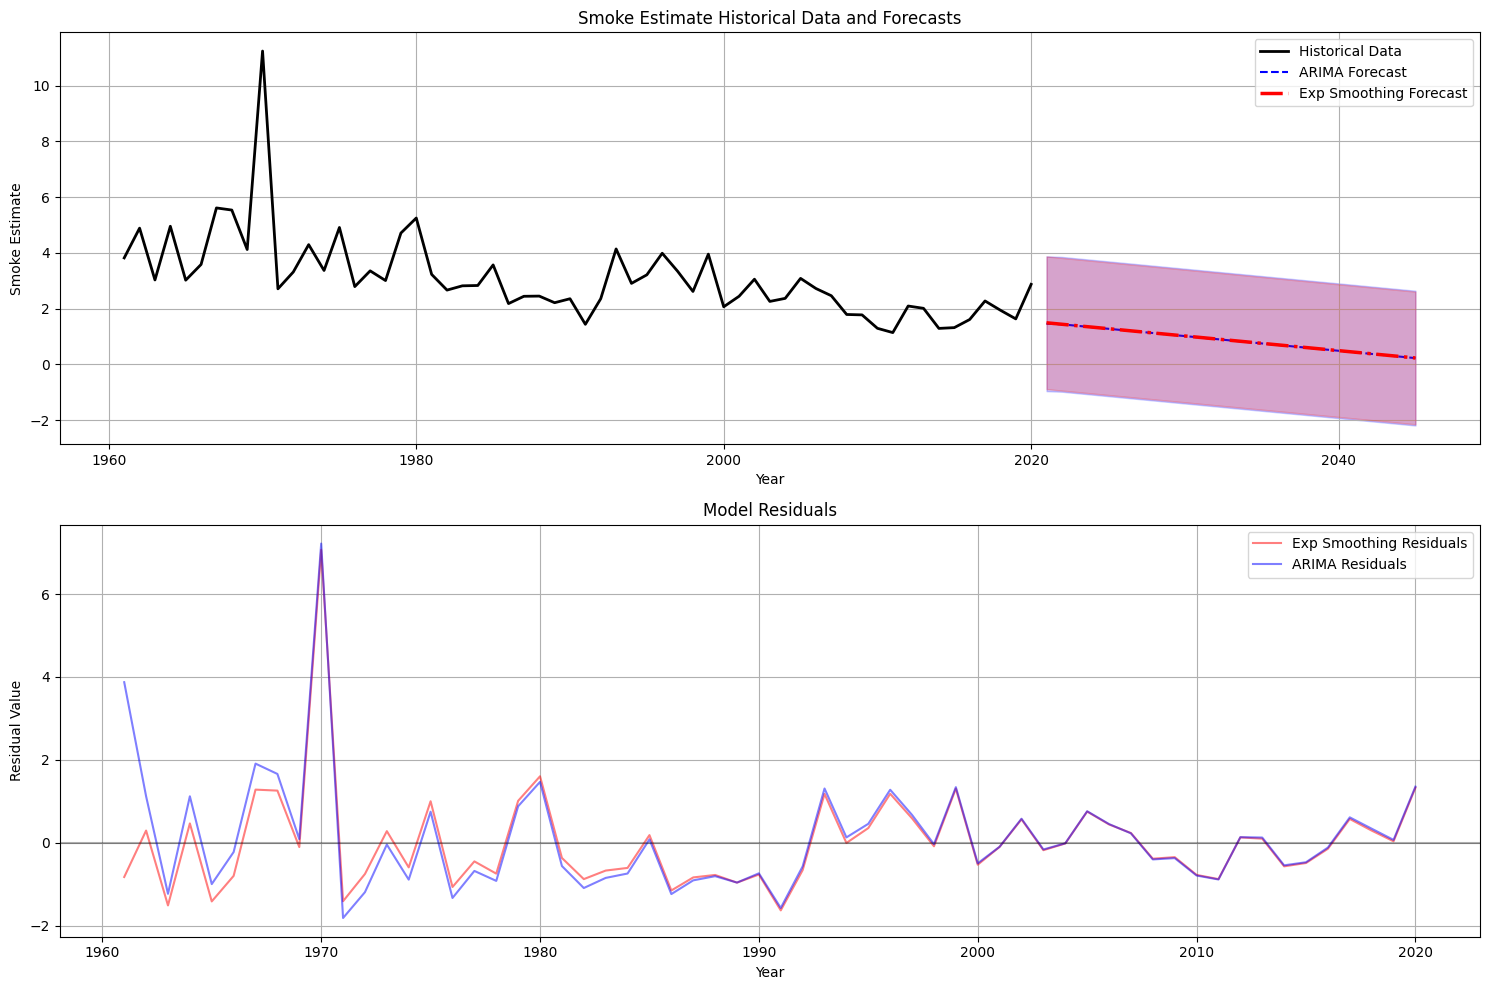


Forecast Summary:

Average Forecast Values for next 25 years:
model
ARIMA                    0.856893
Exponential Smoothing    0.862057
Name: forecast, dtype: float64

Yearly Forecasts:
      Exp_Smoothing     ARIMA
Year                         
2021       1.493148  1.458859
2022       1.440557  1.438330
2023       1.387966  1.384892
2024       1.335375  1.332231
2025       1.282784  1.279552
2026       1.230193  1.226873
2027       1.177603  1.174194
2028       1.125012  1.121515
2029       1.072421  1.068836
2030       1.019830  1.016157
2031       0.967239  0.963478
2032       0.914648  0.910800
2033       0.862057  0.858121
2034       0.809467  0.805442
2035       0.756876  0.752763
2036       0.704285  0.700084
2037       0.651694  0.647405
2038       0.599103  0.594726
2039       0.546512  0.542047
2040       0.493922  0.489368
2041       0.441331  0.436689
2042       0.388740  0.384010
2043       0.336149  0.331331
2044       0.283558  0.278653
2045       0.230967  0.225974


In [16]:
# Prepare the time series data
y = df_estimates_yearly['smoke estimate'].values
years = df_estimates_yearly['year'].values
forecast_periods = 25

try:
    # Create and fit Exponential Smoothing model
    exp_model = ExponentialSmoothing(
        y,
        trend='add',
        seasonal=None,
        initialization_method='estimated'
    )
    exp_fitted = exp_model.fit()
    exp_forecast = exp_fitted.forecast(forecast_periods)
    exp_std_error = np.std(exp_fitted.resid)
    exp_conf_int = stats.norm.ppf(0.975) * exp_std_error

    # Create and fit ARIMA model (no seasonal component)
    arima_model = SARIMAX(
        y,
        order=(1, 1, 1),  # (p,d,q) parameters
        trend='c'  # Include a constant term
    )
    arima_fitted = arima_model.fit(disp=False)
    arima_forecast = arima_fitted.forecast(forecast_periods)
    arima_forecast_conf = arima_fitted.get_forecast(forecast_periods)
    arima_conf_int = arima_forecast_conf.conf_int()

    # Create future years range
    future_years = range(years[-1] + 1, years[-1] + forecast_periods + 1)

    # Store forecasts in DataFrames
    exp_forecasts = pd.DataFrame({
        'year': future_years,
        'forecast': exp_forecast,
        'lower_bound': exp_forecast - exp_conf_int,
        'upper_bound': exp_forecast + exp_conf_int,
        'model': 'Exponential Smoothing'
    })

    arima_forecasts = pd.DataFrame({
        'year': future_years,
        'forecast': arima_forecast,
        'lower_bound': arima_conf_int[:, 0],
        'upper_bound': arima_conf_int[:, 1],
        'model': 'ARIMA'
    })

    # Calculate metrics
    def calculate_metrics(actual, predicted):
        return {
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'MAE': mean_absolute_error(actual, predicted),
            'MAPE': np.mean(np.abs((actual - predicted) / actual)) * 100
        }

    exp_metrics = calculate_metrics(y, exp_fitted.fittedvalues)
    arima_metrics = calculate_metrics(y, arima_fitted.get_prediction(start=0).predicted_mean)

    # Print metrics
    print("\nModel Performance Metrics:")
    print("\nExponential Smoothing:")
    for metric, value in exp_metrics.items():
        print(f"{metric}: {value:.2f}")

    print("\nARIMA:")
    for metric, value in arima_metrics.items():
        print(f"{metric}: {value:.2f}")

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # Plot 1: Historical data and forecasts
    plt.subplot(2, 1, 1)
    # Plot historical data first
    plt.plot(years, y, label='Historical Data', color='black', linewidth=2)

    # Plot ARIMA first (in background)
    plt.plot(arima_forecasts['year'], arima_forecasts['forecast'], 
             label='ARIMA Forecast', color='blue', linestyle='--', zorder=1)
    plt.fill_between(arima_forecasts['year'],
                     arima_forecasts['lower_bound'],
                     arima_forecasts['upper_bound'],
                     color='blue', alpha=0.2, zorder=1)

    # Plot Exponential Smoothing last (in foreground)
    plt.plot(exp_forecasts['year'], exp_forecasts['forecast'], 
             label='Exp Smoothing Forecast', color='red', linestyle='-.', linewidth=2.5, zorder=2)
    plt.fill_between(exp_forecasts['year'],
                     exp_forecasts['lower_bound'],
                     exp_forecasts['upper_bound'],
                     color='red', alpha=0.2, zorder=2)

    plt.title('Smoke Estimate Historical Data and Forecasts')
    plt.xlabel('Year')
    plt.ylabel('Smoke Estimate')
    plt.legend()
    plt.grid(True)

    # Plot 2: Model residuals
    plt.subplot(2, 1, 2)
    plt.plot(years, exp_fitted.resid, label='Exp Smoothing Residuals', color='red', alpha=0.5)
    plt.plot(years, arima_fitted.resid, label='ARIMA Residuals', color='blue', alpha=0.5)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Model Residuals')
    plt.xlabel('Year')
    plt.ylabel('Residual Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print forecasts
    print("\nForecast Summary:")
    print("\nAverage Forecast Values for next 25 years:")
    all_forecasts = pd.concat([exp_forecasts, arima_forecasts])
    print(all_forecasts.groupby('model')['forecast'].mean())

    print("\nYearly Forecasts:")
    forecast_comparison = pd.DataFrame({
        'Year': future_years,
        'Exp_Smoothing': exp_forecasts['forecast'].values,
        'ARIMA': arima_forecasts['forecast'].values
    }).set_index('Year')
    print(forecast_comparison)

    # Optional: Save forecasts to CSV
    # forecast_comparison.to_csv('smoke_estimates_forecasts.csv')

except Exception as e:
    print(f"An error occurred: {str(e)}")
    raise

In [17]:
filtered_df.head()

,Unnamed: 0,name,year,start date,end date,type,distance,size,smoke estimate
0,0,BIG ANTELOPE (5),1961,1961-09-08,1961-10-31,Wildfire,496.813337,55249.740141,31.802062
1,1,HARLOW (5),1961,1961-07-10,1961-10-31,Wildfire,252.905017,43920.841077,47.416340
2,2,RANCHERIA (5),1961,1961-09-02,1961-10-31,Wildfire,352.823877,34233.698603,28.256932
3,3,BOLLINGER RIDGE (5),1961,1961-07-12,1961-10-31,Wildfire,313.182832,32866.053451,30.235517
4,4,Ditch Creek (3),1961,1961-09-01,1961-10-31,Wildfire,754.511077,27269.045936,0.000000


## Visualizing some trends

### Histogram of number of fires
We check for the cummulative number of fires around Lubbock, up to 1800 miles away. The red line indicates the cut-off distance used for modelling which in our case is 650 miles away.

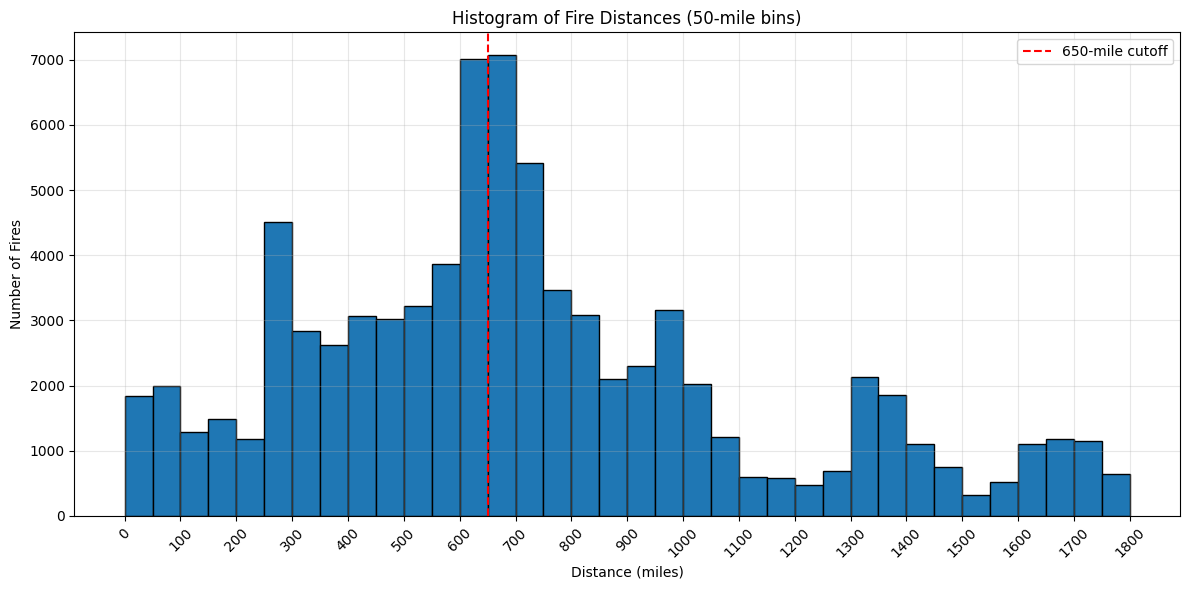

In [18]:
# Create bins from 0 to 1800 in steps of 50
bins = np.arange(0, 1850, 50)

# Create the histogram
plt.figure(figsize=(12, 6))
plt.hist(filtered_df['distance'], bins=bins, edgecolor='black')

# Add a vertical line at the 650-mile cutoff
plt.axvline(x=650, color='red', linestyle='--', label='650-mile cutoff')

# Customize the plot
plt.xlabel('Distance (miles)')
plt.ylabel('Number of Fires')
plt.title('Histogram of Fire Distances (50-mile bins)')
plt.grid(True, alpha=0.3)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(bins[::2], rotation=45)

# Add padding to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

### Cumualtive number of acres of land burned over the years
We can see a sharp upward trend for the area of land burned due to wildfires over the year which is interesting given that both AQI and smoke estimates for Lubbock are trending downwards. This could mean that the number/scale of wildfires around Lubbock has increased over the years but thye might be farther away from Lubbock as years passed which could be why smoke estimates and AQI trend downwards.

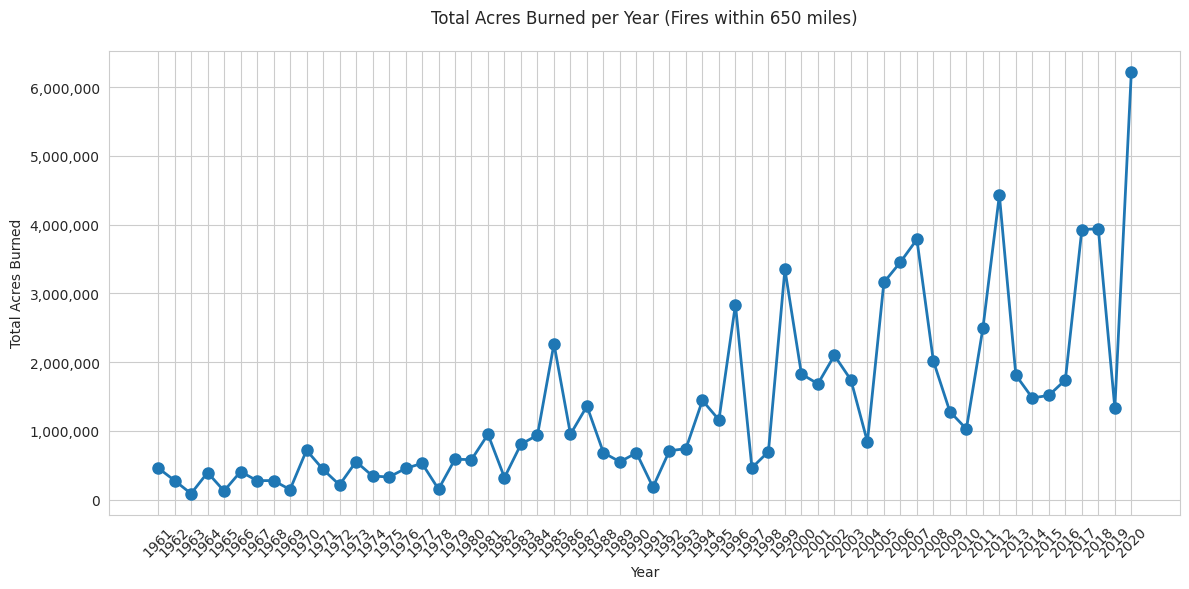

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for fires within 650 miles
df_filtered = df_estimates[df_estimates['distance'] <= 650].copy()

# Group by year and sum the size (acres burned)
yearly_totals = df_filtered.groupby('year')['size'].sum().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot the time series
plt.plot(yearly_totals['year'], yearly_totals['size'], 
         marker='o', linewidth=2, markersize=8)

plt.title('Total Acres Burned per Year (Fires within 650 miles)', pad=20)
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')

# Format y-axis to show numbers in thousands/millions more readable
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Rotate x-axis labels if needed
plt.xticks(yearly_totals['year'], rotation=45)


# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()